In [ ]:
import numpy as np
from numpy.random import randint
import matplotlib.pyplot as plt
from PIL import Image # PIL: Python Imaging Library
import urllib.request 

### 0. 이미지 불러오기

Image size: (520, 346)


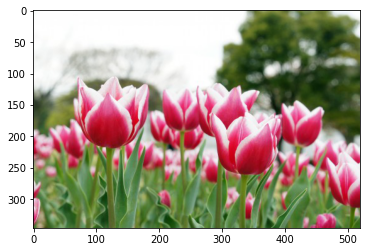

In [ ]:
# 이미지 불러오기
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/jaehosung/ml4se/main/photo.jpg", 
    "flower.jpg"
)
im = Image.open("flower.jpg")
print("Image size:", end=" ") # 520x346 이미지
print(im.size)  
plt.imshow(im)

# 이미지를 각 픽셀의 RGB 값을 가지는 1차원 list로 변환. 
image_data = list(im.convert("RGB").getdata())  
    # 179920(520x346) 길이의 (r,g,b) 튜플 list

### 0. k-평균법

1. 중심점의 초기값 $\mu$ 생성
2. 각 데이터가 속하는 중심점 $\mu$ 찾기
3. 새로운 중심점 계산 $\; (\mu_k = \frac{\sum_{n=1}^N r_{nk} \mathbf{x}_n}{\sum_{n=1}^N r_{nk}})$
4. J 감소폭이 0.1% 미만이면 중단 $\; (J = \sum_{k=1}^K \sum_{n=1}^N \left \{ r_{nk} \sum_{i=1}^D ([\mathbf{x}_n]_i - [\mu_k]_i )^2 \right \})$


In [ ]:
def calc_closest_cluster(x, mu_list):
    min_sq_dist = 256 * 256 * 3
    k = 0 # cluster index
    K = len(mu_list)
    
    for j in range(K):
        mu_j = mu_list[j]
        sq_dist = sum([x_i * x_i for x_i in x - mu_j])
        if sq_dist < min_sq_dist:
            min_sq_dist = sq_dist
            k = j
    
    return k, min_sq_dist

In [ ]:
def calc_new_clusters(x_list, mu_list):
    N = len(x_list)
    K = len(mu_list)
    
    mu_idx_list = np.zeros(N, dtype=int)
    x_sum_list = np.zeros((K,3))
    x_num_list = np.zeros(K, dtype=int)
    mu_list_new = [np.array([0,0,0])] * K
    J_new = 0.0
    
    for pixel_idx, x in enumerate(x_list):
        #x = np.array(x) # tuple -> ndarray
        k, min_sq_dist = calc_closest_cluster(x, mu_list)
        mu_idx_list[pixel_idx] = k
        x_sum_list[k] += x
        x_num_list[k] += 1  
        J_new += min_sq_dist  

    for i in range(K):
        if x_num_list[i] is not 0:  # 0으로 나누는 에러를 방지
            mu_list_new[i] = np.array(x_sum_list[i] / x_num_list[i], dtype=int) 
    
    return mu_list_new, J_new, mu_idx_list, x_num_list

In [ ]:
# k-평균법 활용하여 클러스터링
def calc_k_means(image_data, K, MAX_ITER_NUM):

    x_list = image_data 
        # 트레이닝 셋 데이터: (1차원 [(R,G,B)] list) 
    mu_list = np.random.randint(256,size=(K,3)) 
        # 클러스터 대표점 리스트 [[r,g,b],...[r,g,b]] 
        # 임의의 값으로 초기화.  
    J = 0.0  # 제곱 에러(square error)

    for iter_num in range(MAX_ITER_NUM):
        mu_list_new, J_new, mu_idx_list, x_num_list = calc_new_clusters(x_list, mu_list)
        
        print("itration: %d" % (iter_num + 1))
        print("New centers:", end=" ")
        print([x.tolist() for x in mu_list_new])
        print("Num of data in each cluster:", end=" ")
        print(x_num_list)
        print("J=%d" % J_new)
        print("========================")

        # J의 변화가 0.1% 미만이면 종료
        if iter_num > 0 and J - J_new < J * 0.001:
            mu_list = mu_list_new

            print("J difference < 0.1%")
            print("Iteration ends")
            print("========================")
            break

        mu_list = mu_list_new
        J = J_new
        
    return mu_list, mu_idx_list

In [1]:
# 클러스터링된 대표색으로 새로운 이미지 생성.
# mu_list: {mu_k}, mu for each cluster (K clusters)
# mu_idx_list: {k_n}, k for each x_n (N points)
def calc_clustered_image_data(mu_list, mu_idx_list):
    new_image_data = [(0, 0, 0)] * len(mu_idx_list)
    
    for pixel_idx, point in enumerate(mu_idx_list):
        new_image_data[pixel_idx] = tuple(mu_list[mu_idx_list[pixel_idx]])
    
    return new_image_data

In [ ]:
# 파라미터 설정
K = 3 # the number of clusters
MAX_ITER_NUM = 30

print("========================")
print("Number of clusters: K=%d" % K)
print("========================")

# k-평균법 실행
mu_list, mu_idx_list = calc_k_means(image_data, K, MAX_ITER_NUM) 
  # mu_list: {mu_k}, mu for each cluster (K clusters)
  # mu_idx_list: {k_n}, k for each x_n (N points)
clustered_image_data = calc_clustered_image_data(mu_list, mu_idx_list)

Number of clusters: K=3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in long_scalars
  


itration: 1
New centers: [[-9223372036854775808, -9223372036854775808, -9223372036854775808], [106, 92, 57], [225, 208, 210]]
Num of data in each cluster: [    0 98832 81088]
J=1587787477
itration: 2
New centers: [[28, 54, 17], [117, 99, 65], [232, 215, 219]]
Num of data in each cluster: [ 8113 98272 73535]
J=891212800
itration: 3
New centers: [[44, 70, 25], [130, 103, 74], [234, 219, 223]]
Num of data in each cluster: [22621 87185 70114]
J=744725237
itration: 4
New centers: [[53, 78, 30], [139, 105, 80], [235, 222, 226]]
Num of data in each cluster: [32384 79866 67670]
J=677053365
itration: 5
New centers: [[60, 84, 34], [146, 105, 85], [236, 224, 228]]
Num of data in each cluster: [40514 73328 66078]
J=644801207
itration: 6
New centers: [[65, 88, 37], [153, 105, 89], [236, 226, 229]]
Num of data in each cluster: [47246 67721 64953]
J=624525215
itration: 7
New centers: [[69, 91, 40], [158, 104, 93], [237, 227, 230]]
Num of data in each cluster: [53107 62704 64109]
J=610665034
itration:

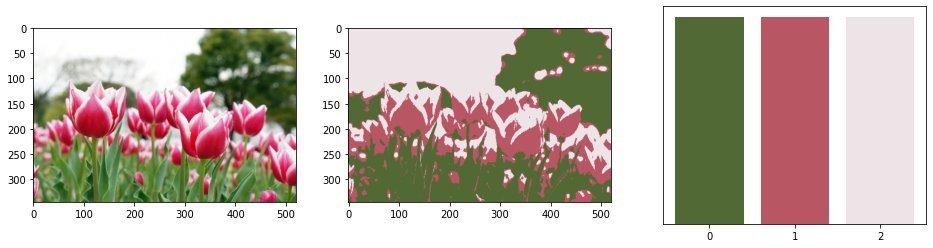

In [ ]:
# 그림으로 결과 출력
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

# 기존 이미지 시각화
im.putdata(image_data)
axs[0].imshow(im)

# 클러스터링 이미지 시각화
im.putdata(clustered_image_data)  # k-평균법 사용하여 추출한 색만으로 이루어진 이미지
axs[1].imshow(im)

# 추출된 색 시각화
axs[2].set_xticks(np.arange(0, len(mu_list), 1.0))
axs[2].set_yticks([])
for idx, rgb in enumerate(mu_list):
    axs[2].bar(idx, 1, color=np.array(rgb) / 255)